In [1]:
import numpy as np 
import os
from astropy.io import fits
import healpy as hp
from scipy.interpolate import RegularGridInterpolator, griddata
from healpy.projector import GnomonicProj
import datetime
from zoneinfo import ZoneInfo
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.units as u
import matplotlib.image as mpig
from astropy.wcs import WCS
from gwcs.wcstools import wcs_from_points
from astropy.modeling.projections import Sky2Pix_TAN, Sky2Pix_STG, Sky2Pix_ARC, Sky2Pix_ZEA, Sky2Pix_SIN
#from astropy.modeling import projections
import asdf 
import matplotlib.pyplot as plt
import cv2
import rawpy

In [2]:
def check_projection(zen, r_real):
    str_proj = ['TAN', 'STG', 'ARC', 'ZEA', 'SIN']
    f_proj = [Sky2Pix_TAN(), Sky2Pix_STG(), Sky2Pix_ARC(), Sky2Pix_ZEA(), Sky2Pix_SIN()]
    if zen ==0:
        zen = 0.1
    zen_rad = np.deg2rad(zen)
    r_tan = np.tan(zen_rad) /zen_rad
    r_stg = np.tan(zen_rad/2.) *2/zen_rad
    r_arc = 1.
    r_zea = np.sin(zen_rad/2.) *2/zen_rad
    r_sin = np.sin(zen_rad)/zen_rad
    r_proj = np.array([r_tan, r_stg, r_arc, r_zea, r_sin])
    dr = np.abs(r_real -r_proj)
    r_id = np.argmin(dr)
    #print(r_proj)
    print(str_proj[r_id])
    return f_proj[r_id]

class HealpixData():
    def __init__(self, nside):
        img = np.arange(hp.nside2npix(nside))
        #lat, lon = hp.pix2ang(nside, img, nest=True)
        #self.lat = lat
        #self.lon = lon
        lon, lat = hp.pix2ang(nside, img, lonlat=True)
        self.lat = lat#np.deg2rad(90. -lat)
        self.lon = lon#np.deg2rad(lon)

class ImageData():
    def __init__(self, img=None, x=None, y=None):
        self.img = img
        self.x = x
        self.y = y

class all_sky_image():
    def __init__(self, filepath, sex_ext, rdata, proj_size):
        self.filepath = filepath
        self.sex = sex_ext
        self.rawdata = rdata
        self.fvalue = 0.
        self.cutdata = None
        self.hdata = HealpixData(1024) # healpix data for projection, nside=1024
        self.cen_rd = None # the (ra, dec) of image center
        self.bdata = HealpixData(4) # healpix data for rotation, nside=4
        self.divdeg = [45., 65., 90.] # the boundaries to divide the FoV into three segments
        self.divnum = [0., 0., 0.] # the number of healpix above the boundaries.
        self.func = lambda x,y,z: hp.vec2pix(1024,x,y,z)#,nest=True) # function for hdata
        self.new_gwcs = 0
        self.gwcs_radec = None
        self.tab = None
        self.dlon = None
        self.fproj = Sky2Pix_ARC() # the image projection, the default is ARC
        self.xproj = proj_size
        self.yproj = proj_size
        self.px = None
        self.py = None
        self.pdata = ImageData()
        self.frame = None        
        self.cen = [0, 0, 0]

    def _set_gwcs_radec(self, p_degree):
        tab_radec = SkyCoord(self.tab['index_ra'], self.tab['index_dec'], unit=(u.deg, u.deg),frame='icrs')
        xy = ((self.tab['field_x'],self.tab['field_y']))
        rd0 = self.cen_rd
        self.gwcs_radec = wcs_from_points(xy, tab_radec, proj_point=rd0,\
                             projection=self.fproj,poly_degree=p_degree, polynomial_type='polynomial')

    def _set_cutdata(self):
        col1 = self.cen[0]-self.cen[2]
        col2 = self.cen[0]+self.cen[2]
        row1 = self.cen[1]-self.cen[2]
        row2 = self.cen[1]+self.cen[2]
        self.cutdata = self.rawdata[row1:row2,col1:col2]             

    def _set_pxy(self):
        proj_nx = np.arange(self.xproj)
        proj_ny = np.arange(self.yproj)
        self.px, self.py = np.meshgrid(proj_nx, proj_ny)
        self.px = self.px.flatten()
        self.py = self.py.flatten()

    def _update_tab(self, r_radec):
        sra = str(round(r_radec.ra.deg,3))
        sdec = str(round(r_radec.dec.deg,3))
    
        sel_fit = fits.PrimaryHDU(np.array(self.pdata.img))
        sel_fit.writeto(self.filepath+'sel_fit.fits',overwrite=True)
        os.system('solve-field '+self.filepath+'sel_fit.fits -O --use-source-extractor'\
                  +' --source-extractor-path '+self.sex \
                    +' --x-column xc --y-column yc --sort-column flux --no-plots'\
                        +' --width ' +str(self.xproj)+ ' --height ' +str(self.yproj) \
                            +' --ra '+sra+' --dec '+sdec+' --radius 10' \
                                +' --cpulimit 20 --scale-units arcsecperpix '\
                                    +' --scale-low 75 --scale-h 105 >> ' +self.filepath+'sel_fit.txt')
        if os.path.exists(self.filepath+'sel_fit.corr'):
            star_tab = fits.open(self.filepath+'sel_fit.corr')[1].data           
            os.remove(self.filepath+'sel_fit.corr') 
            star_x = griddata((self.px, self.py), self.pdata.x.flatten(), \
                              (star_tab['field_x'], star_tab['field_y']), method='linear')
            star_y = griddata((self.px, self.py), self.pdata.y.flatten(), \
                              (star_tab['field_x'], star_tab['field_y']), method='linear')
            star_tab['field_x'] = star_x
            star_tab['field_y'] = star_y
            self.tab = np.append(self.tab, star_tab)
        else:
            print("The region centered on the astronomical coordinates ("+sra+","+sdec+") could not be solved.")

    def _set_bdata(self):
        # [11.7, 23.6, 35.7, 48.2, 60.0, 70.5, 80.4, 90.0]
        # [   4,    8,   16,   16,   16,   16,   16,   16] 
        # If nside = 4, the first 7 circles need to be solved.
        #coord = SkyCoord(self.bdata.lon, np.pi/2-self.bdata.lat, unit=(u.rad, u.rad))
        coord = SkyCoord(self.bdata.lon, self.bdata.lat, unit=(u.deg, u.deg))
        ang = self.cen_rd.separation(coord).deg
        id = np.argsort(ang)
        self.bdata.lat = self.bdata.lat[id]
        self.bdata.lon = self.bdata.lon[id]
        self.divnum[0] = len(self.bdata.lat[ang < self.divdeg[0]])
        self.divnum[1] = len(self.bdata.lat[ang < self.divdeg[1]])
        self.divnum[2] = len(self.bdata.lat[ang < self.divdeg[2]])

    def interpol_area(self):
        ny, nx = self.rawdata.shape
        xrange = np.arange(nx)
        yrange = np.arange(ny)

        fr = RegularGridInterpolator((yrange,xrange), self.rawdata ,method='linear', bounds_error=False)
        fdata = fr((self.pdata.y, self.pdata.x))
        self.pdata.img = np.nan_to_num(fdata, nan=0.0, posinf=0.0, neginf=0.0)
        if np.sum(np.isnan(fdata)) > len(fdata)*0.3:
            self.pdata.img = [0]
            print("This region is skipped.")
            #return self.pdata.img

    def rot_area(self, hrot):
        rot_proj = GnomonicProj(rot=(hrot[0],hrot[1]),xsize=self.xproj,ysize=self.yproj)
        glon = rot_proj.projmap(self.hdata.lon, self.func)
        #glon = np.rad2deg(glon)
        glat = rot_proj.projmap(self.hdata.lat, self.func)
        #glat = 90.-np.rad2deg(glat)
        gx, gy = self.gwcs_radec.backward_transform(glon,glat)
        self.pdata.x = gx
        self.pdata.y = gy
        if self.new_gwcs==0 :
            self.pdata.x = gx -self.cen[2] + self.cen[0]
            self.pdata.y = gy -self.cen[2] + self.cen[1]
        self.interpol_area()
    
    def estimate_center(self):
        # 1st to estimate center
        width, height = self.rawdata.shape
        self.cen = [round(height/2.), round(width/2.), round(width/10.)] ## xcenter, ycenter, radius
        if width > height :
            self.cen[2] = round(height/10.)

        self._set_cutdata()    
        sel_fit = fits.PrimaryHDU(np.array(self.cutdata))
        sel_fit.writeto(self.filepath+'sel_fit.fits',overwrite=True)
        os.system('solve-field '+self.filepath+'sel_fit.fits -O --use-source-extractor'\
                  +' --source-extractor-path '+self.sex \
                    +' --x-column xc --y-column yc --sort-column flux --no-plots'\
                        +' --cpulimit 30 >> ' +self.filepath+'sel_fit.txt')
        if os.path.exists(self.filepath+'sel_fit.corr'):
            
            self.tab = fits.open(self.filepath+'sel_fit.corr')[1].data
            os.remove(self.filepath+'sel_fit.corr') 
            w = WCS(fits.open(self.filepath+'sel_fit.wcs')[0].header)
            cen_rd = w.wcs_pix2world([[self.cen[2], self.cen[2]]], 1)[0]
            self.cen_rd = SkyCoord(cen_rd[0], cen_rd[1], unit=(u.deg, u.deg))
            os.remove(self.filepath+'sel_fit.wcs') 

            self._set_gwcs_radec(p_degree=1)     
            ra0, dec0 = self.gwcs_radec(0,0)
            coord0 = SkyCoord(ra0, dec0, unit=(u.deg, u.deg))
            dist0 = self.cen[2]*np.sqrt(2.0)
            ang_dist = self.cen_rd.separation(coord0).deg
            self.fvalue = dist0 /np.deg2rad(ang_dist) # f = radius/theta
            print("x,y,radius,fvalue:",[self.cen, self.fvalue])
        else:
            print("The zenith region can not be solved.")    

    def get_tab(self):
        self._set_pxy()    
        self.estimate_center()    
        self._set_bdata()     
        self.tab['field_x'] = np.round(self.tab['field_x']-self.cen[2] + self.cen[0])
        self.tab['field_y'] = np.round(self.tab['field_y']-self.cen[2] + self.cen[1])
        print('The center area is solved.')

        for i in range(self.divnum[2]): 
            #rot_lat = 90.-np.rad2deg(self.bdata.lat[i])
            #rot_lon = np.rad2deg(self.bdata.lon[i])
            #rot_radec = SkyCoord(self.bdata.lon[i], np.pi/2 -self.bdata.lat[i], unit=(u.rad, u.rad))
            rot_lat = self.bdata.lat[i]
            rot_lon = self.bdata.lon[i]
            rot_radec = SkyCoord(self.bdata.lon[i], self.bdata.lat[i], unit=(u.deg, u.deg))
            print(f"@ lat:{round(rot_lat,3)}, lon:{round(rot_lon,3)}, count:{i+1}/{self.divnum[2]}")
            self.rot_area([rot_lon, rot_lat])    
            if len(self.pdata.img) == 1:
                continue 
            self._update_tab(rot_radec)

            if i==(self.divnum[0]-1) or i==(self.divnum[1]-1):
                uu, u_ind = np.unique(self.tab['index_ra'], return_index=True)
                self.tab = self.tab[u_ind]
                self.tab = self.tab[~np.isnan(self.tab['field_x'])]

                sradec = SkyCoord(self.tab['index_ra'], self.tab['index_dec'], unit=(u.deg, u.deg),frame='icrs')
                angular_distance = self.cen_rd.separation(sradec).deg
                zen_id = np.argmax(angular_distance)
                zen_deg = angular_distance[zen_id]
                print(zen_deg)
                rdis = np.sqrt((self.cen[0]-self.tab['field_x'][zen_id])**2.+(self.cen[1]-self.tab['field_y'][zen_id])**2.)
                r_real = rdis/np.deg2rad(zen_deg)/self.fvalue
                print(r_real)               
                self.fproj = check_projection(zen_deg, r_real)  
                self._set_gwcs_radec(p_degree=4)
                self.new_gwcs = 1

        # get the table 
        self.tab = self.tab[~np.isnan(self.tab['field_x'])]       
        uu, u_ind = np.unique(self.tab['index_ra'], return_index=True)
        self.tab = self.tab[u_ind]  
        self._set_gwcs_radec(p_degree=6)  

        self.tab = Table([self.tab['field_x'],self.tab['field_y'],\
                        self.tab['index_ra'],self.tab['index_dec'],\
                            self.tab['field_ra'],self.tab['field_dec'],\
                                self.tab['match_weight'],self.tab['MAG_AUTO'],self.tab['FLUX_AUTO']],\
                names=['field_x','field_y','index_ra','index_dec','field_ra','field_dec',\
                        'match_weight','mag_auto','flux_auto']) 

In [ ]:
sex_ext = '/usr/local/bin/sex ' # source extractor
ipath = 'your image path'
fname = 't2020-10-19_04-24-26.jpg'

img = mpig.imread(ipath+fname)
rr = img[:,:,0]
gg = img[:,:,1]
bb = img[:,:,2]
gimg = (0.299*rr + 0.587*gg + 0.114*bb)

In [4]:
result = all_sky_image(ipath, sex_ext, gimg, 600)
result.get_tab()

x,y,radius,fvalue: [[2592, 1728, 346], np.float64(1039.9219881708934)]
The center area is solved.
@ lat:30.0, lon:45.0, count:1/96
@ lat:19.471, lon:56.25, count:2/96
@ lat:30.0, lon:67.5, count:3/96
@ lat:41.81, lon:56.25, count:4/96
@ lat:41.81, lon:33.75, count:5/96
@ lat:19.471, lon:33.75, count:6/96
@ lat:41.81, lon:78.75, count:7/96
@ lat:9.594, lon:45.0, count:8/96
@ lat:9.594, lon:67.5, count:9/96
@ lat:19.471, lon:78.75, count:10/96
@ lat:54.341, lon:45.0, count:11/96
@ lat:30.0, lon:22.5, count:12/96
@ lat:54.341, lon:75.0, count:13/96
@ lat:0.0, lon:56.25, count:14/96
@ lat:30.0, lon:90.0, count:15/96
@ lat:0.0, lon:33.75, count:16/96
@ lat:9.594, lon:22.5, count:17/96
@ lat:41.81, lon:11.25, count:18/96
@ lat:66.444, lon:67.5, count:19/96
@ lat:54.341, lon:15.0, count:20/96
@ lat:0.0, lon:78.75, count:21/96
@ lat:9.594, lon:90.0, count:22/96
@ lat:41.81, lon:101.25, count:23/96
@ lat:-9.594, lon:45.0, count:24/96
@ lat:19.471, lon:11.25, count:25/96
@ lat:66.444, lon:22.5, 

/tmp/ipykernel_89016/2544492063.py:4: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(result.rawdata))


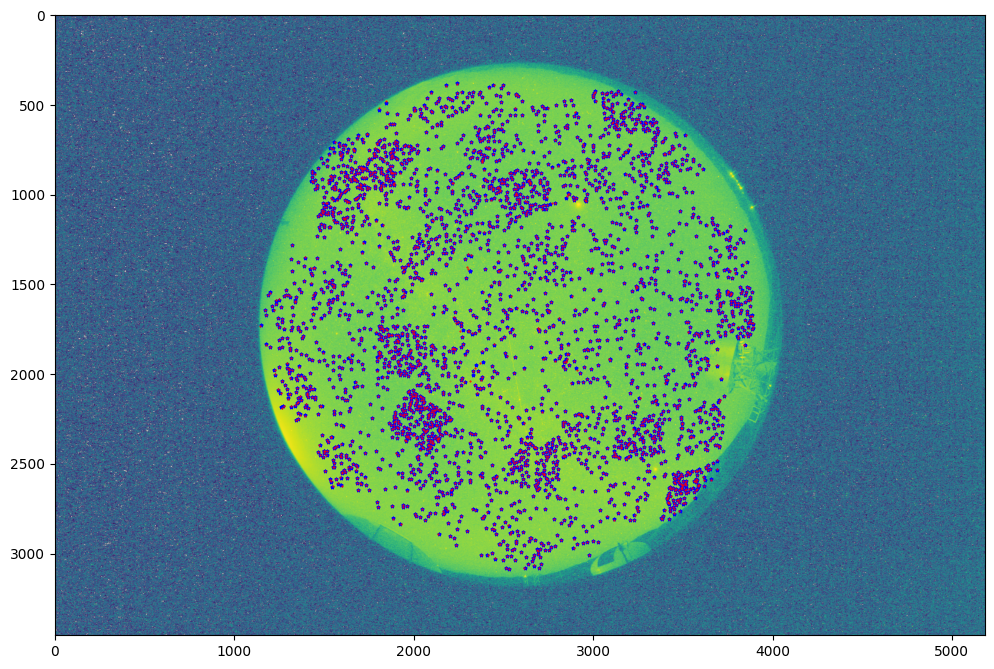

In [5]:
gx, gy = result.gwcs_radec.backward_transform(result.tab['index_ra'], result.tab['index_dec'])

fig,ax = plt.subplots(figsize=(12,12),dpi=100)
ax.imshow(np.log10(result.rawdata))
plt.scatter(gx,gy, c='blue',s=5,marker='*')
plt.scatter(result.tab['field_x'],result.tab['field_y'],s=1,marker='.',c='red')#,edgecolors='red', linewidths=0.5)
plt.show()

In [6]:
tree = {"wcs": result.gwcs_radec}
wcs_file = asdf.AsdfFile(tree)
ofile = ipath+'result_gwcs_radec.asdf'
wcs_file.write_to(ofile)
result.tab.write(ipath + 'img_stars_coords.csv',format='ascii.csv',overwrite=True)

In [7]:
fname = 't2020-10-19_06-14-38.jpg'
img = mpig.imread(ipath+fname)
rr = img[:,:,0]
gg = img[:,:,1]
bb = img[:,:,2]
gimg = (0.299*rr + 0.587*gg + 0.114*bb)

In [8]:
result = all_sky_image(ipath, sex_ext, gimg, 600)
result.get_tab()

x,y,radius,fvalue: [[2592, 1728, 346], np.float64(1027.0175731674428)]
The center area is solved.
@ lat:30.0, lon:90.0, count:1/96
@ lat:19.471, lon:78.75, count:2/96
@ lat:41.81, lon:78.75, count:3/96
@ lat:30.0, lon:67.5, count:4/96
@ lat:41.81, lon:101.25, count:5/96
@ lat:19.471, lon:101.25, count:6/96
@ lat:9.594, lon:90.0, count:7/96
@ lat:41.81, lon:56.25, count:8/96
@ lat:9.594, lon:67.5, count:9/96
@ lat:54.341, lon:75.0, count:10/96
@ lat:30.0, lon:112.5, count:11/96
@ lat:19.471, lon:56.25, count:12/96
@ lat:54.341, lon:105.0, count:13/96
@ lat:0.0, lon:78.75, count:14/96
@ lat:30.0, lon:45.0, count:15/96
@ lat:9.594, lon:112.5, count:16/96
@ lat:0.0, lon:101.25, count:17/96
@ lat:41.81, lon:123.75, count:18/96
@ lat:54.341, lon:45.0, count:19/96
@ lat:66.444, lon:67.5, count:20/96
@ lat:19.471, lon:123.75, count:21/96
@ lat:0.0, lon:56.25, count:22/96
@ lat:-9.594, lon:90.0, count:23/96
@ lat:9.594, lon:45.0, count:24/96
@ lat:66.444, lon:112.5, count:25/96
@ lat:41.81, lon

/tmp/ipykernel_89016/2544492063.py:4: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(result.rawdata))


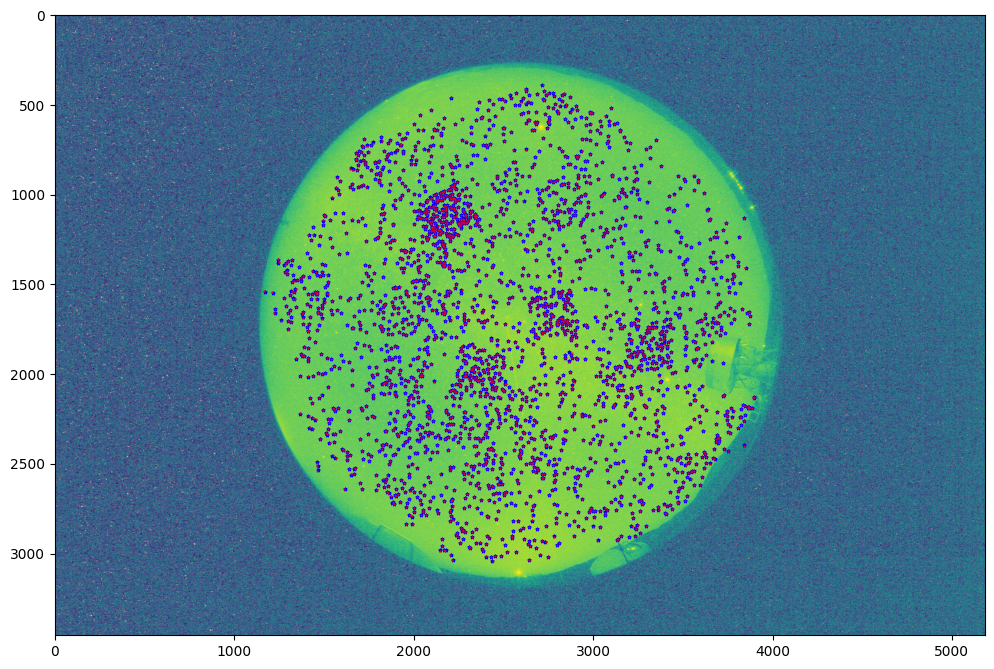

In [9]:
gx, gy = result.gwcs_radec.backward_transform(result.tab['index_ra'], result.tab['index_dec'])

fig,ax = plt.subplots(figsize=(12,12),dpi=100)
ax.imshow(np.log10(result.rawdata))
plt.scatter(gx,gy, c='blue',s=5,marker='*')
plt.scatter(result.tab['field_x'],result.tab['field_y'],s=1,marker='.',c='red')#,edgecolors='red', linewidths=0.5)
plt.show()

In [10]:
tree = {"wcs": result.gwcs_radec}
wcs_file = asdf.AsdfFile(tree)
ofile = ipath+'result_gwcs_radec_n.asdf'
wcs_file.write_to(ofile)
result.tab.write(ipath + 'img_stars_coords_n.csv',format='ascii.csv',overwrite=True)